## 2.3. PyMC3 の概要

以下のモデルを検討する.

$$
    \begin{align*}
        \theta &\sim \text{Unif}(\theta | 0, 1) \\
        y_n | \theta &\sim \text{Bern}(y_n | \theta), \ n = 1, \dots, N
    \end{align*}
$$

In [9]:
import arviz as az
import numpy as np
import pymc3 as pm
from scipy import stats

In [1]:
# 観測データ
y_obs = [1, 0, 0, 1, 1, 1, 0, 1, 1, 0]

In [3]:
with pm.Model() as model:
    # 推論対象とするパラメータの事前分布
    theta = pm.Uniform("theta", lower=0, upper=1)
    # 尤度関数 (観測変数が従う確率分布)
    y = pm.Bernoulli("y", p=theta, shape=len(y_obs), observed=y_obs)

print(model.basic_RVs)

[theta_interval__ ~ TransformedDistribution, y ~ Bernoulli]


In [4]:
with model:
    # MCMC による推論
    trace = pm.sample(
        draws=6000,                 # サンプルサイズ
        tune=2000,                  # バーンイン (ウォームアップ) 期間
        step=pm.NUTS(),             # MCMC アルゴリズム (NUTS)
        chains=3,                   # チェーン数
        random_seed=1,
        return_inferencedata=True,  # ArviZ の InferenceData を返す
    )

Multiprocess sampling (3 chains in 4 jobs)
NUTS: [theta]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 2_000 tune and 6_000 draw iterations (6_000 + 18_000 draws total) took 13 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.581,0.138,0.322,0.829,0.002,0.001,7890.0,11166.0,1.0


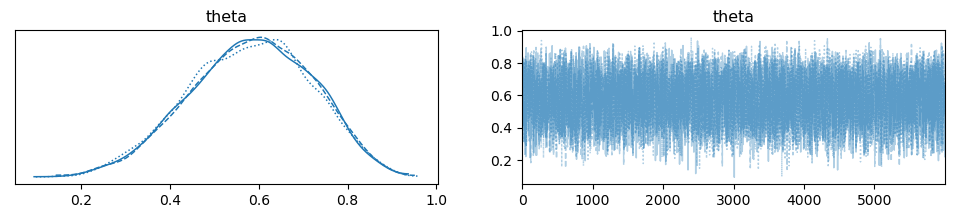

In [6]:
az.plot_trace(trace)
az.summary(trace)

In [7]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

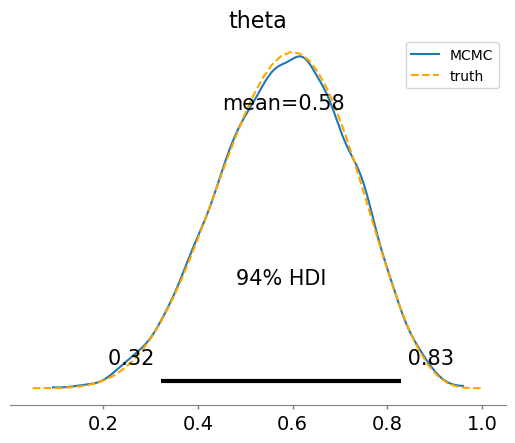

In [11]:
N, n = len(y_obs), np.sum(y_obs)
true_posterior = stats.beta(1 + n, 1 + N - n)

ax = az.plot_posterior(trace)
ax.lines[0].set_label("MCMC")

xx = np.linspace(*ax.get_xlim())
ax.plot(xx, true_posterior.pdf(xx), ls="--", color="orange", label="truth")
ax.legend()